- title: "Differential Protein Expression"
- author: "Margaret Paiva"
- author: "Gilad Silberberg"
- date: "2021/12/21"
- output: R notebook

In [1]:
# cran packages
x <- c('dplyr',
       'data.table',
       'tidyr',   
       'tidyverse', 
       'ggplot2', 
       'viridis')
# bioconductor packages
y <- c('DEP', 
       'SummarizedExperiment')

In [2]:
# # install bioconductor packages
# if (!requireNamespace("BiocManager", quietly=TRUE))
#     install.packages("BiocManager")
# BiocManager::install(y)

In [3]:
# # install cran packages
# for (pkg in x) {
#     if (!pkg %in% rownames(installed.packages())) {install.packages(pkg)}
# }

In [4]:
# load packages
load_lib <- function(x) {
    suppressPackageStartupMessages(library(x, character.only = TRUE))
}
invisible(lapply(c(x, y), load_lib))

## Data

The SummarizedExperiment object has a couple of specifications. The log2-transformed assay data and the specified rowData and colData columns are prerequisites for the subsequent analysis steps.
- The assay data is log2-transformed. 
- Its rownames depict the protein/gene names. The rowData contains, amongst others, the ‘name’ and ‘ID’ columns.
- The colData contains the experimental design and thereby the sample annotation. Thereby the colData includes the ‘label’, ‘condition’ and ‘replicate’ columns as well as a newly generated ‘ID’ column.  

In [5]:
# External users use API to query data
# Internal users can access the data at
# s3://championsoncology.bioinformatics/Repos/general_analysis/AMLproteomics/general_preproc_QC/
data <- readRDS('./data/AMLproteomics_imp_norm_se_list2021-04-06.rds')
data <- data$lenient  # choose conservative or lenient
# The following is to format the data to match the function requirement 
colData(data) <- subset(colData(data), select = -c(condition, replicate)) 
names(colData(data))[names(colData(data)) == 'Treatment.history'] <- 'condition'
colData(data)$replicate <- colData(data)$ID 
colData(data) <- subset(colData(data), select = c(ID, label, condition, replicate))
data <- data[, !is.na(colData(data)$condition)] # remove samples with NA condition

In [6]:
# This is the annotated data format (SummarizedExperiment object) in R
# equivalent to AnnData in Python
data

class: SummarizedExperiment 
dim: 4688 44 
metadata(0):
assays(1): ''
rownames(4688): A2M A8MWD9 ... ZYX ZZEF1
rowData names(6): hgnc_symbol ProteinGroupId ... imputed num_NAs
colnames(44): CTG_2226 CTG_2227 ... CTG_3679 CTG_3680
colData names(4): ID label condition replicate

In [7]:
# assay data
dim(assay(data))
head(assay(data), 2)

[1] 4688   44

,CTG_2226,CTG_2227,CTG_2228,CTG_2229,CTG_2232,CTG_2233,CTG_2234,CTG_2235,CTG_2236,CTG_2238,...,CTG_3441,CTG_3659,CTG_3660,CTG_3661,CTG_3663,CTG_3670,CTG_3673,CTG_3674,CTG_3679,CTG_3680
A2M,15.386,15.65601,16.38401,14.84999,15.84399,13.96596,13.74704,12.77808,14.961,16.10501,...,14.04397,14.16703,14.633,14.19599,14.85599,16.511,16.103,13.30307,16.764,14.975
A8MWD9,18.122,18.84500,18.90100,19.04300,18.11900,18.30000,18.77900,18.71000,19.251,18.82300,...,19.03400,18.22900,18.100,18.99500,18.63300,18.798,18.729,18.82300,18.432,18.730


In [8]:
# row info
dim(rowData(data))
head(as.data.frame(rowData(data)), 2)

[1] 4688    6

,hgnc_symbol,ProteinGroupId,ID,name,imputed,num_NAs
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
A2M,A2M,P01023,P01023,A2M,FALSE,0
A8MWD9,NA,A8MWD9,A8MWD9,A8MWD9,FALSE,0


In [9]:
# col info
dim(colData(data))
head(as.data.frame(colData(data)), 2)

[1] 44  4

,ID,label,condition,replicate
,<chr>,<chr>,<chr>,<chr>
CTG_2226,CTG_2226,CTG_2226,PRETREATED,CTG_2226
CTG_2227,CTG_2227,CTG_2227,PRETREATED,CTG_2227


In [10]:
# summary of pretreated vs. naive
table(colData(data)$condition, useNA = "always")


     NAIVE PRETREATED       <NA> 
        15         29          0 

## Processing

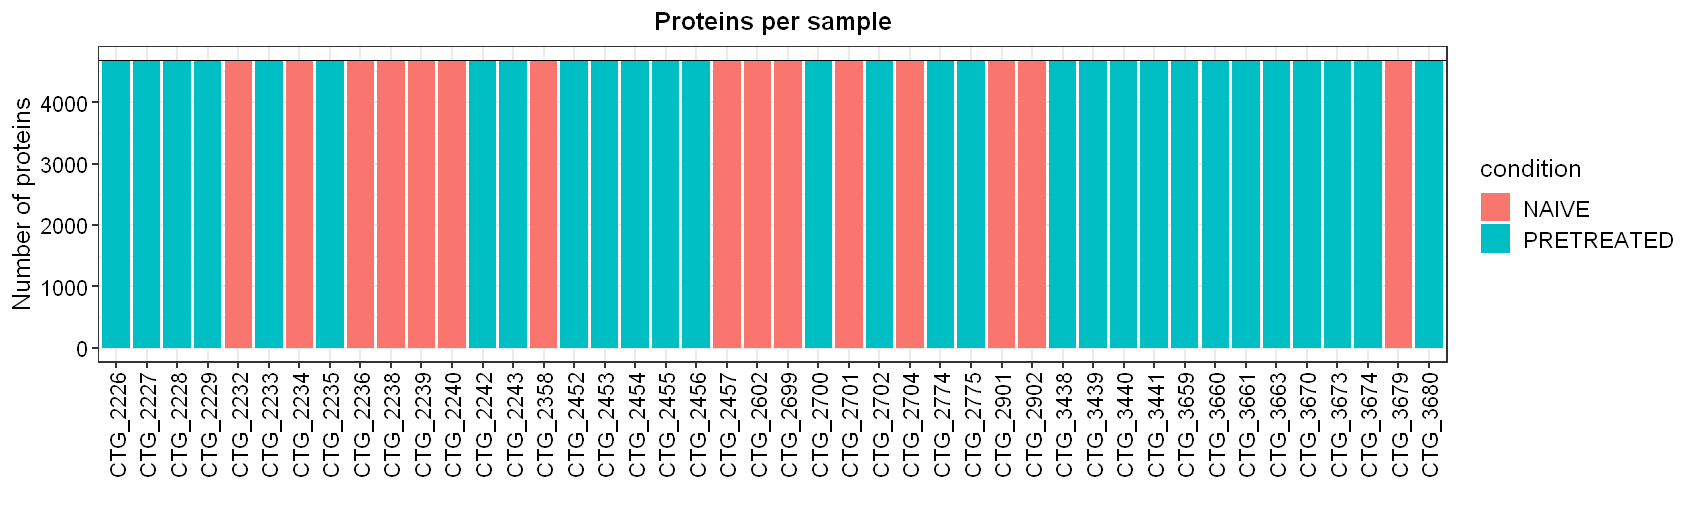

In [11]:
# Plot a barplot of the number of identified proteins per samples
options(repr.plot.width=13, repr.plot.height=4, repr.plot.res=130)
plot_numbers(data)

This is because this data set has been imputed or filtered to have no missing proteins per sample

In [12]:
# Normalize the data
data_norm <- normalize_vsn(data)

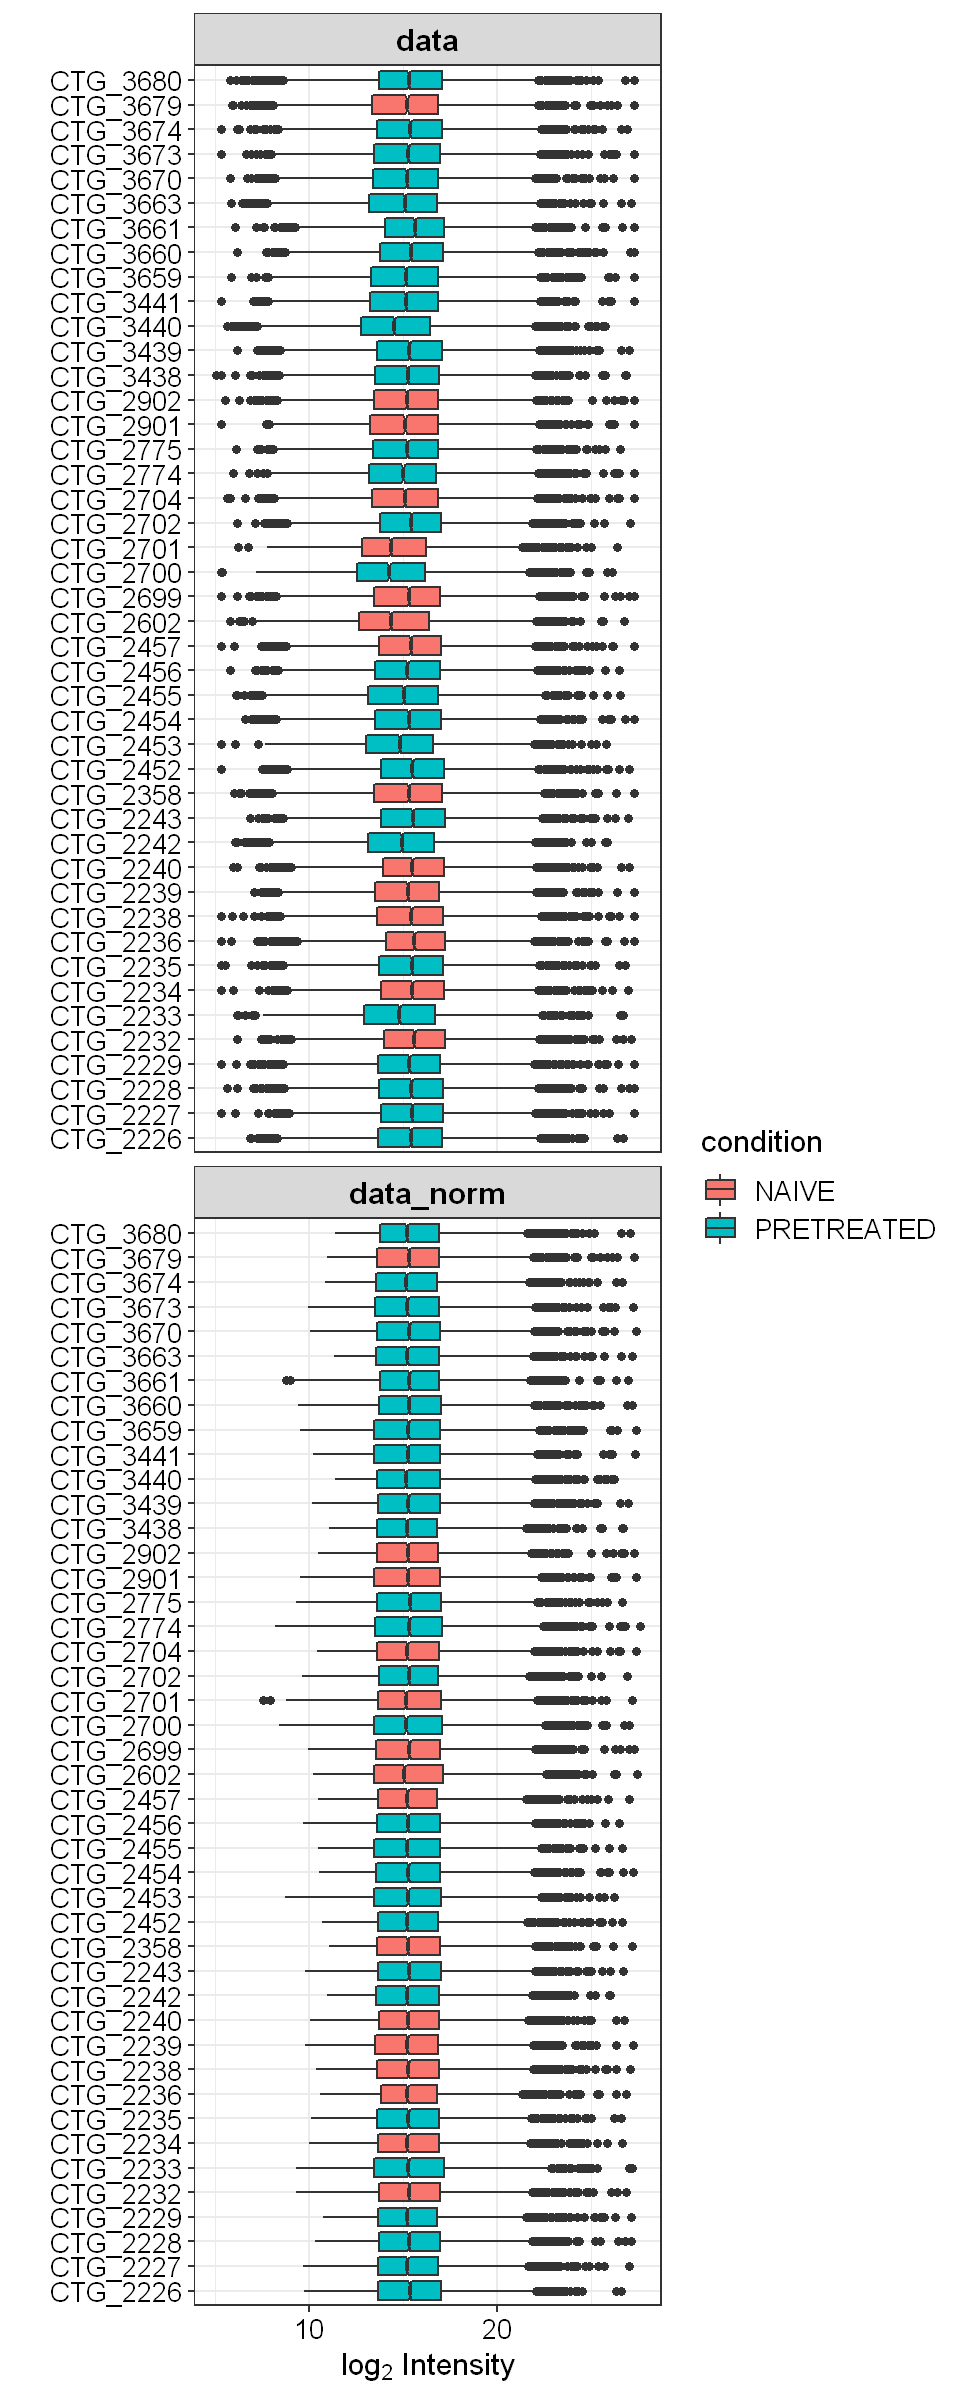

In [13]:
# Visualize normalization by boxplots for all samples before and after normalization
options(repr.plot.width=6, repr.plot.height=15, repr.plot.res=160)
plot_normalization(data, data_norm)

After normalization, the data are median centered. 

## Differential protein expression

In [15]:
# Test treated sample versus naive
# data_diff <- test_diff(data_norm, type = "control", control = "NAIVE")
data_diff <- test_diff(data_norm, type = "manual", 
                       test = "PRETREATED_vs_NAIVE")

Tested contrasts: PRETREATED_vs_NAIVE



In [16]:
data_diff

class: SummarizedExperiment 
dim: 4688 44 
metadata(0):
assays(1): ''
rownames(4688): A2M A8MWD9 ... ZYX ZZEF1
rowData names(11): name hgnc_symbol ... PRETREATED_vs_NAIVE_p.adj
  PRETREATED_vs_NAIVE_p.val
colnames(44): CTG_2226 CTG_2227 ... CTG_3679 CTG_3680
colData names(4): ID label condition replicate

In [36]:
# Denote significant proteins based on user defined cutoffs
dep <- add_rejections(data_diff, 
                      alpha = 0.2, 
                      lfc = log2(1.5)) 

In [37]:
dep

class: SummarizedExperiment 
dim: 4688 44 
metadata(0):
assays(1): ''
rownames(4688): A2M A8MWD9 ... ZYX ZZEF1
rowData names(13): name hgnc_symbol ... significant
  PRETREATED_vs_NAIVE_significant
colnames(44): CTG_2226 CTG_2227 ... CTG_3679 CTG_3680
colData names(4): ID label condition replicate

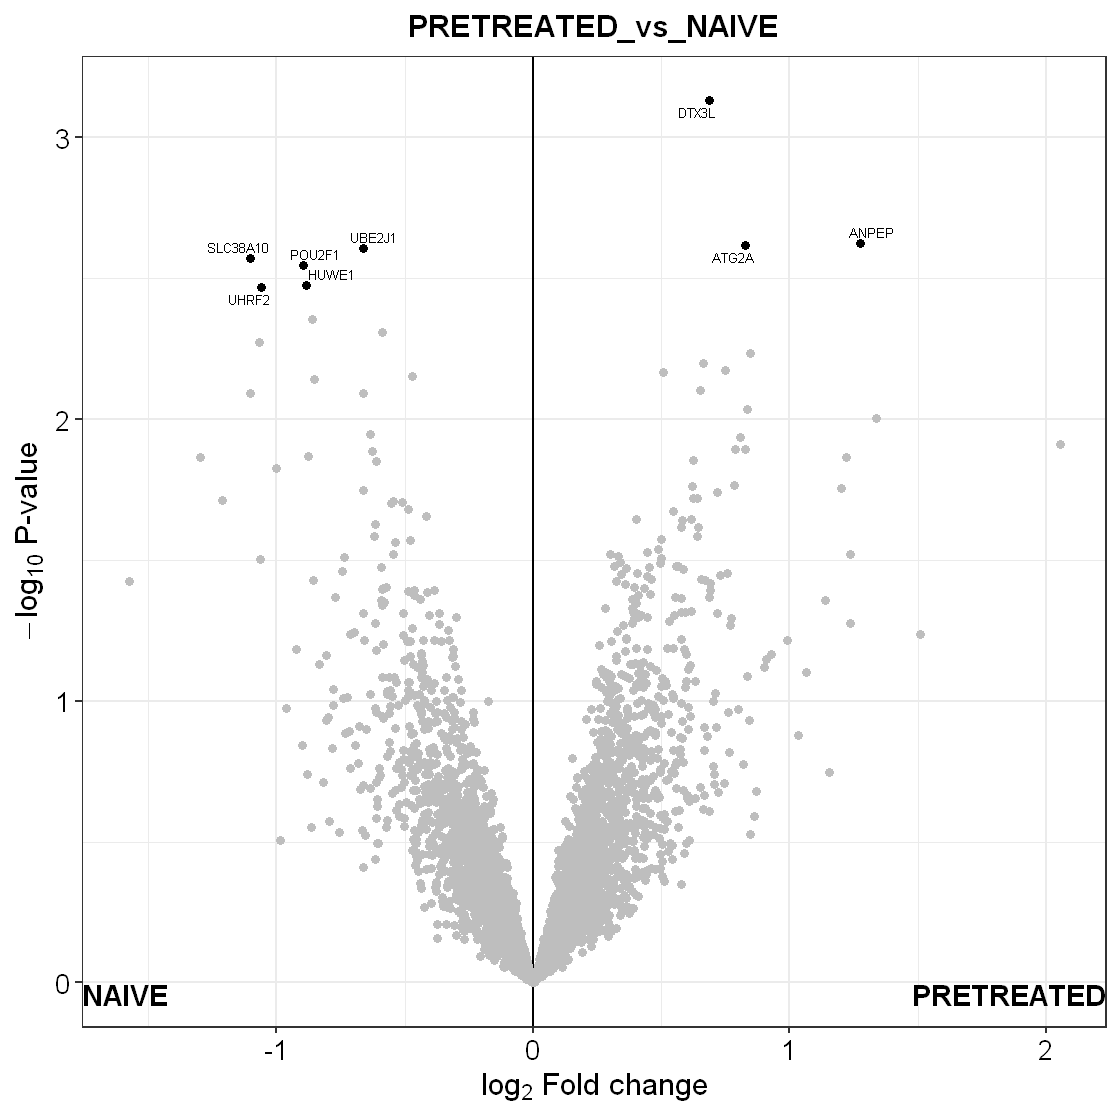

In [38]:
# Plot a volcano plot for the contrast
options(repr.plot.width=7, repr.plot.height=7, repr.plot.res=160)
plot_volcano(dep, contrast = "PRETREATED_vs_NAIVE", 
             label_size = 2, add_names = TRUE)

In [52]:
plot_single <- function(dep, proteins, type = c("contrast", "centered"), plot = TRUE) {
  # Reference: function from the DEP package
  # Show error if inputs are not the required classes
  assertthat::assert_that(inherits(dep, "SummarizedExperiment"),
    is.character(proteins),
    is.character(type),
    is.logical(plot),
    length(plot) == 1)

  # Show error if inputs do not contain required columns
  type <- match.arg(type)

  row_data <- rowData(dep, use.names = FALSE)

  if(any(!c("label", "condition", "replicate") %in% colnames(colData(dep)))) {
    stop("'label', 'condition' and/or 'replicate' columns are not present in '",
         deparse(substitute(dep)),
         "'\nRun make_se() or make_se_parse() to obtain the required columns",
         call. = FALSE)
  }
  if(length(grep("_p.adj|_diff", colnames(row_data))) < 1) {
    stop("'[contrast]_diff' and '[contrast]_p.adj' columns are not present in '",
         deparse(substitute(dep)),
         "'\nRun test_diff() to obtain the required columns",
         call. = FALSE)
  }
  if(!"name" %in% colnames(row_data)) {
    stop("'name' column not present in '",
         deparse(substitute(dep)),
         "'\nRun make_se() or make_se_parse() to obtain the required columns",
         call. = FALSE)
  }

  # Show error if an unvalid protein name is given
  if(all(!proteins %in% row_data$name)) {
    if(length(proteins) == 1) {
      rows <- grep(substr(proteins, 1, nchar(proteins) - 1),row_data$name)
      possibilities <- row_data$name[rows]
    } else {
      rows <- lapply(proteins, function(x)
        grep(substr(x, 1, nchar(x) - 1),row_data$name))
      possibilities <- row_data$name[unlist(rows)]
    }

    if(length(possibilities) > 0) {
      possibilities_msg <- paste0(
        "Do you mean: '",
        paste0(possibilities, collapse = "', '"),
        "'")
    } else {
      possibilities_msg <- NULL
    }
    stop("please run `plot_single()` with a valid protein names in the 'proteins' argument\n",
         possibilities_msg,
         call. = FALSE)
  }
  if(any(!proteins %in% row_data$name)) {
    proteins <- proteins[proteins %in% row_data$name]
    warning("Only used the following protein(s): '",
            paste0(proteins, collapse = "', '"),
            "'")
  }

  # Single protein
  subset <- dep[proteins]
                     
  options(dplyr.summarise.inform = FALSE)

  # Plot either the centered log-intensity values
  # per condition ('centered') or the average fold change of conditions
  # versus the control condition ('contrast') for a single protein
  if(type == "centered") {
    # Obtain protein-centered fold change values
    means <- rowMeans(assay(subset), na.rm = TRUE)
    df_reps <- data.frame(assay(subset) - means) %>%
      rownames_to_column() %>%
      gather(ID, val, -rowname) %>%
      left_join(., data.frame(colData(subset)), by = "ID")
    df_reps$replicate <- as.factor(df_reps$replicate)
    df <- df_reps %>%
      group_by(condition, rowname) %>%
      summarize(mean = mean(val, na.rm = TRUE),
        sd = sd(val, na.rm = TRUE),
        n = n()) %>%
      mutate(error = qnorm(0.975) * sd / sqrt(n),
             CI.L = mean - error,
             CI.R = mean + error) %>%
      as.data.frame()
    df$rowname <- parse_factor(df$rowname, levels = proteins)

    # Plot the centered intensity values for the replicates and the mean
    p <- ggplot(df, aes(condition, mean)) +
      geom_hline(yintercept = 0) +
      geom_col(colour = "black", fill = "grey") +
      geom_point(data = df_reps, aes(condition, val, col = replicate),
                 shape = 18, size = 5, position = position_dodge(width=0.3)) +
      geom_errorbar(aes(ymin = CI.L, ymax = CI.R), width = 0.3) +
      labs(
          x = "Condition",
          y = expression(log[2]~"Intensity"~"(\u00B195% CI)"),
          col = "Model") +
      facet_wrap(~rowname) +
      theme_DEP2()
  }
  if(type == "contrast") {
    # Select values for a single protein
    df <- rowData(subset, use.names = FALSE) %>%
      data.frame() %>%
      select(name,
             ends_with("_diff"),
             ends_with("_CI.L"),
             ends_with("_CI.R")) %>%
      gather(var, val, -name) %>%
      mutate(contrast = gsub("_diff|_CI.L|_CI.R", "", var),
             var = gsub(".*_", "", var)) %>%
      spread(var, val)
    df$name <- parse_factor(df$name, levels = proteins)
    suffix <- get_suffix(df$contrast)
    if(length(suffix)) {df$contrast <- delete_suffix(df$contrast)}
    # Plot the average fold change of conditions versus the control condition
    p <- ggplot(df, aes(contrast, diff)) +
      geom_hline(yintercept = 0) +
      geom_col(colour = "black", fill = "grey") +
      geom_errorbar(aes(ymin = CI.L, ymax = CI.R), width = 0.3) +
      labs(x = suffix,
           y = expression(log[2]~"Fold change"~"(\u00B195% CI)")) +
      facet_wrap(~name) +
      theme_DEP2()
  }
  if(plot) {
    return(p)
  } else {
    if(type == "centered") {
      df <- df %>%
        select(rowname, condition, mean, CI.L, CI.R)
      colnames(df) <- c("protein", "condition",
        "log2_intensity", "CI.L", "CI.R")
    }
    if(type == "contrast") {
      df <- df %>%
        select(name, contrast, diff, CI.L, CI.R) %>%
        mutate(contrast = paste0(contrast, suffix))
      colnames(df) <- c("protein", "contrast",
        "log2_fold_change", "CI.L", "CI.R")
    }
    return(df)
  }
}

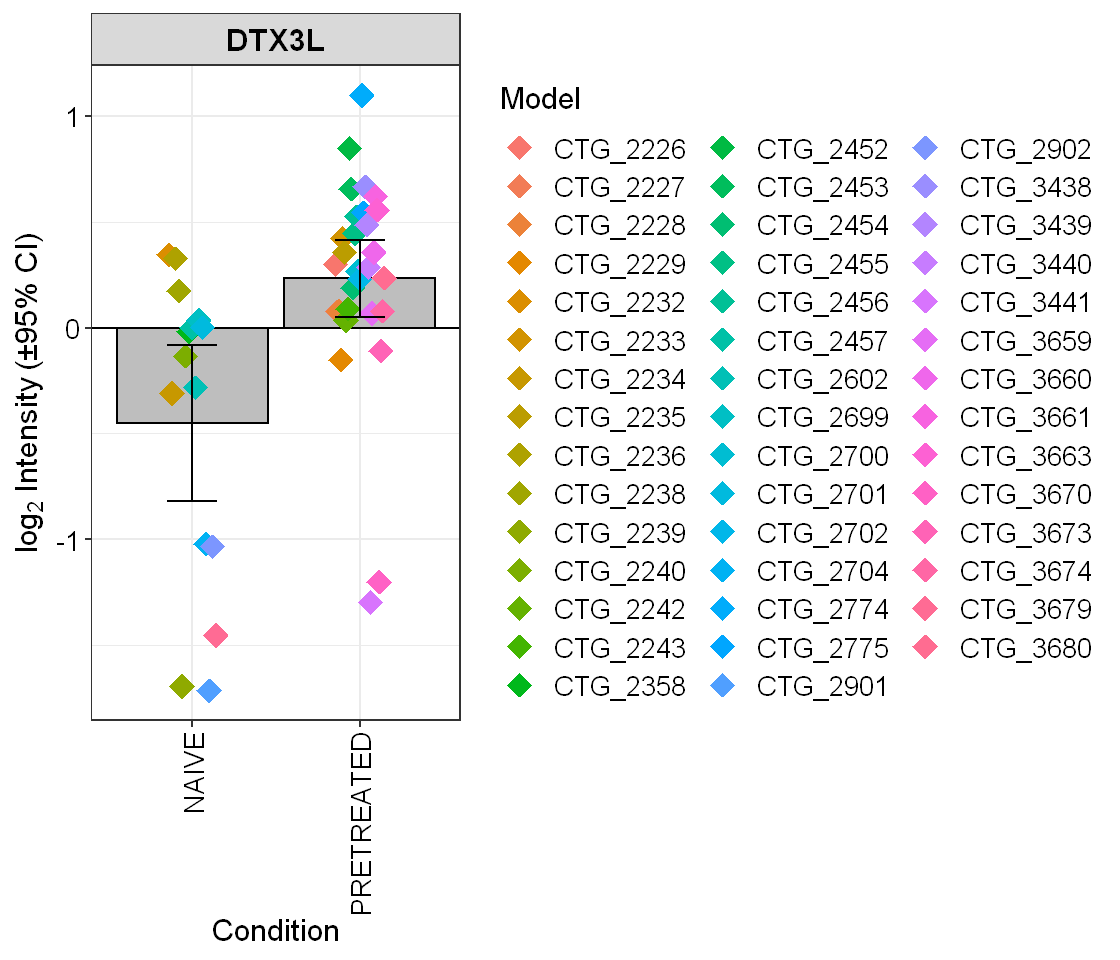

In [53]:
options(repr.plot.width=7, repr.plot.height=6, repr.plot.res=160)
plot_single(dep, proteins = "DTX3L", type = "centered")

## Example
This is the example data set from the package.

In [136]:
data <- UbiLength
# We filter for contaminant proteins and decoy database hits, 
# which are indicated by "+" in the columns "Potential.contaminants" and "Reverse", respectively. 
data <- filter(data, Reverse != "+", Potential.contaminant != "+")
head(data, 1)

,Protein.IDs,Majority.protein.IDs,Protein.names,Gene.names,Fasta.headers,Peptides,Razor...unique.peptides,Unique.peptides,LFQ.intensity.Ubi4_1,LFQ.intensity.Ubi4_2,...,LFQ.intensity.Ubi6_3,LFQ.intensity.Ctrl_1,LFQ.intensity.Ctrl_2,LFQ.intensity.Ctrl_3,LFQ.intensity.Ubi1_1,LFQ.intensity.Ubi1_2,LFQ.intensity.Ubi1_3,Only.identified.by.site,Reverse,Potential.contaminant
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,A0AV96-2;B7Z8Z7;A0AV96;D6R9D6;D6RBS9;D6REZ6;D6R9M7;D6RCT1;D6RBP6;D6RA49;D6RFL5;Q5T0W7;Q8TBY0-2;Q8TBY0-3;Q9NQ94-5;Q8TBY0;Q9NQ94-6;Q9NQ94-3;Q9NQ94-2;F8W9F8;Q9NQ94-4;Q9NQ94,A0AV96-2;B7Z8Z7;A0AV96;D6R9D6;D6RBS9,RNA-binding protein 47,RBM47,>sp|A0AV96-2|RBM47_HUMAN Isoform 2 of RNA-binding protein 47 OS=Homo sapiens GN=RBM47;>tr|B7Z8Z7|B7Z8Z7_HUMAN RNA-binding protein 47 OS=Homo sapiens GN=RBM47 PE=2 SV=1;>sp|A0AV96|RBM47_HUMAN RNA-binding protein 47 OS=Homo sapiens GN=RBM47 PE=1 SV=2;>tr|D6R,7,7,7,35787000,24701000,...,32705000,25898000,31275000,23076000,27664000,32314000,31097000,,,


In [137]:
# data %>% group_by(Gene.names) %>% summarize(frequency = n()) %>% 
#   arrange(desc(frequency)) %>% filter(frequency > 1)

In [138]:
# Make unique names using the annotation in the "Gene.names" column 
# as primary names and the annotation in "Protein.IDs" as name 
# for those that do not have an gene name.
data_unique <- make_unique(data, "Gene.names", "Protein.IDs", delim = ";")
head(data_unique, 1)

,Protein.IDs,Majority.protein.IDs,Protein.names,Gene.names,Fasta.headers,Peptides,Razor...unique.peptides,Unique.peptides,LFQ.intensity.Ubi4_1,LFQ.intensity.Ubi4_2,...,LFQ.intensity.Ctrl_2,LFQ.intensity.Ctrl_3,LFQ.intensity.Ubi1_1,LFQ.intensity.Ubi1_2,LFQ.intensity.Ubi1_3,Only.identified.by.site,Reverse,Potential.contaminant,name,ID
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,A0AV96-2;B7Z8Z7;A0AV96;D6R9D6;D6RBS9;D6REZ6;D6R9M7;D6RCT1;D6RBP6;D6RA49;D6RFL5;Q5T0W7;Q8TBY0-2;Q8TBY0-3;Q9NQ94-5;Q8TBY0;Q9NQ94-6;Q9NQ94-3;Q9NQ94-2;F8W9F8;Q9NQ94-4;Q9NQ94,A0AV96-2;B7Z8Z7;A0AV96;D6R9D6;D6RBS9,RNA-binding protein 47,RBM47,>sp|A0AV96-2|RBM47_HUMAN Isoform 2 of RNA-binding protein 47 OS=Homo sapiens GN=RBM47;>tr|B7Z8Z7|B7Z8Z7_HUMAN RNA-binding protein 47 OS=Homo sapiens GN=RBM47 PE=2 SV=1;>sp|A0AV96|RBM47_HUMAN RNA-binding protein 47 OS=Homo sapiens GN=RBM47 PE=1 SV=2;>tr|D6R,7,7,7,35787000,24701000,...,31275000,23076000,27664000,32314000,31097000,,,,RBM47,A0AV96-2


In [139]:
# Generate a SummarizedExperiment object using an experimental design
LFQ_columns <- grep("LFQ.", colnames(data_unique)) # get LFQ column numbers
experimental_design <- UbiLength_ExpDesign
data_se <- make_se(data_unique, LFQ_columns, experimental_design)

# Generate a SummarizedExperiment object by parsing condition information from the column names
LFQ_columns <- grep("LFQ.", colnames(data_unique)) # get LFQ column numbers
data_se_parsed <- make_se_parse(data_unique, LFQ_columns)

# Let's have a look at the SummarizedExperiment object
data_se

class: SummarizedExperiment 
dim: 2941 12 
metadata(0):
assays(1): ''
rownames(2941): RBM47 UBA6 ... ATXN2.3 X6RHB9
rowData names(13): Protein.IDs Majority.protein.IDs ... name ID
colnames(12): Ubi4_1 Ubi4_2 ... Ubi1_2 Ubi1_3
colData names(4): label ID condition replicate

In [140]:
head(as.data.frame(rowData(data_se)), 1)

,Protein.IDs,Majority.protein.IDs,Protein.names,Gene.names,Fasta.headers,Peptides,Razor...unique.peptides,Unique.peptides,Only.identified.by.site,Reverse,Potential.contaminant,name,ID
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
RBM47,A0AV96-2;B7Z8Z7;A0AV96;D6R9D6;D6RBS9;D6REZ6;D6R9M7;D6RCT1;D6RBP6;D6RA49;D6RFL5;Q5T0W7;Q8TBY0-2;Q8TBY0-3;Q9NQ94-5;Q8TBY0;Q9NQ94-6;Q9NQ94-3;Q9NQ94-2;F8W9F8;Q9NQ94-4;Q9NQ94,A0AV96-2;B7Z8Z7;A0AV96;D6R9D6;D6RBS9,RNA-binding protein 47,RBM47,>sp|A0AV96-2|RBM47_HUMAN Isoform 2 of RNA-binding protein 47 OS=Homo sapiens GN=RBM47;>tr|B7Z8Z7|B7Z8Z7_HUMAN RNA-binding protein 47 OS=Homo sapiens GN=RBM47 PE=2 SV=1;>sp|A0AV96|RBM47_HUMAN RNA-binding protein 47 OS=Homo sapiens GN=RBM47 PE=1 SV=2;>tr|D6R,7,7,7,,,,RBM47,A0AV96-2


In [141]:
as.data.frame(colData(data_se))

,label,ID,condition,replicate
,<chr>,<chr>,<chr>,<dbl>
Ubi4_1,Ubi4_1,Ubi4_1,Ubi4,1
Ubi4_2,Ubi4_2,Ubi4_2,Ubi4,2
Ubi4_3,Ubi4_3,Ubi4_3,Ubi4,3
Ubi6_1,Ubi6_1,Ubi6_1,Ubi6,1
Ubi6_2,Ubi6_2,Ubi6_2,Ubi6,2
Ubi6_3,Ubi6_3,Ubi6_3,Ubi6,3
Ctrl_1,Ctrl_1,Ctrl_1,Ctrl,1
Ctrl_2,Ctrl_2,Ctrl_2,Ctrl,2
Ctrl_3,Ctrl_3,Ctrl_3,Ctrl,3
